In [8]:
import torch
from torchvision.transforms import v2
from torchvision.io import decode_image
from pathlib import Path
import matplotlib.pyplot as plt 
from torchvision import tv_tensors
import random

In [2]:
image_dir = "../DataCleaning/Sorted_Images/BCC/s-prd-416761910.jpg"

In [3]:
img = decode_image(str(Path(image_dir)))

In [4]:
# this cell taken from helpers.py from pytorch 
from torchvision.utils import draw_bounding_boxes, draw_keypoints, draw_segmentation_masks
from torchvision.transforms.v2 import functional as TF

def plot(imgs, row_title=None, bbox_width=3, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            points = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target

                    # Conversion necessary because draw_bounding_boxes() only
                    # work with this specific format.
                    #if tv_tensors.is_rotated_bounding_format(boxes.format):
                        #boxes = v2.ConvertBoundingBoxFormat("xyxyxyxy")(boxes)
                elif isinstance(target, tv_tensors.KeyPoints):
                    points = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = TF.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=bbox_width)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)
            if points is not None:
                img = draw_keypoints(img, points, colors="red", radius=10)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [5]:
transform = v2.Compose(
    [
        v2.RandomResizedCrop(size=(224, 244), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
out = transform(img)

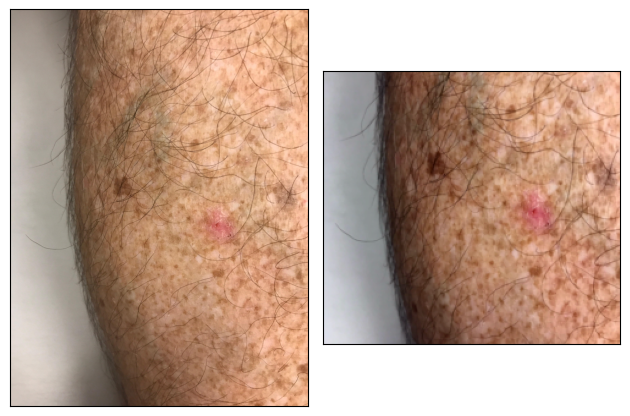

In [12]:
plot([img, out])

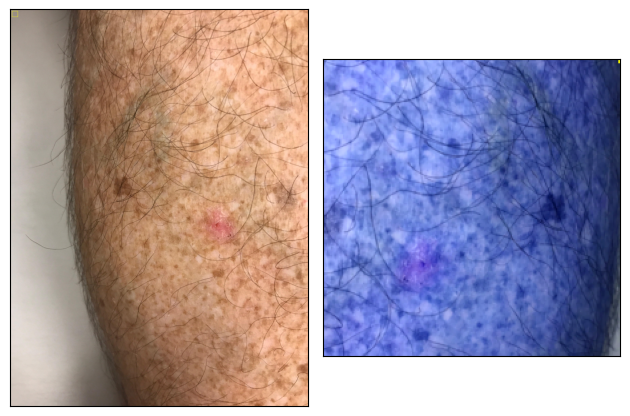

In [15]:
boxes = tv_tensors.BoundingBoxes(
    [
        [20, 20, 80, 80],
    
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms2 = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])

out_img, out_boxes = transforms2(img, boxes)

plot([(img, boxes), (out_img, out_boxes)])

Class: Actinic Keratosis


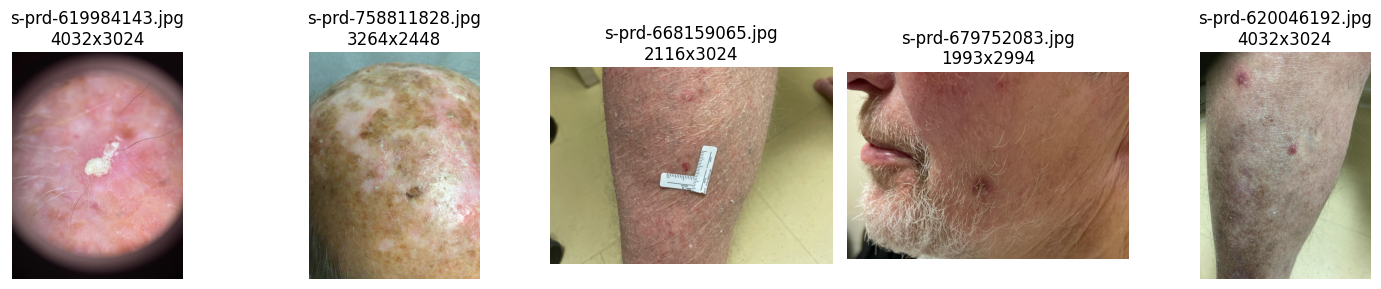

Class: BCC


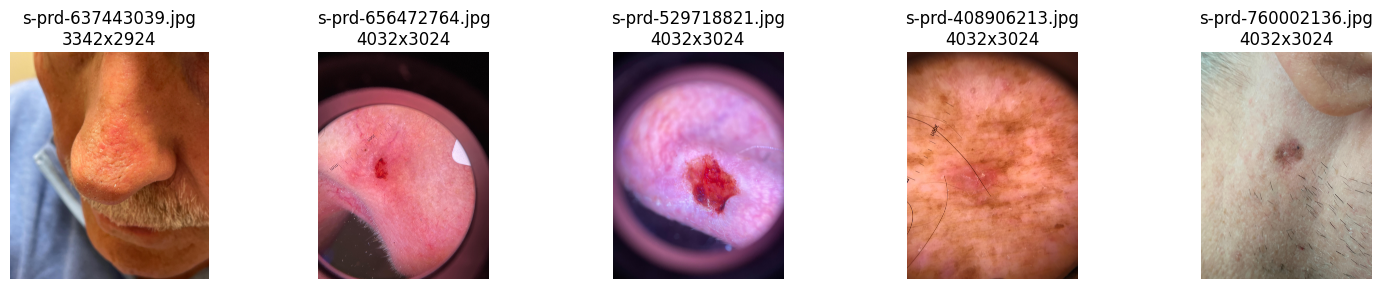

Class: Benign_or_Other


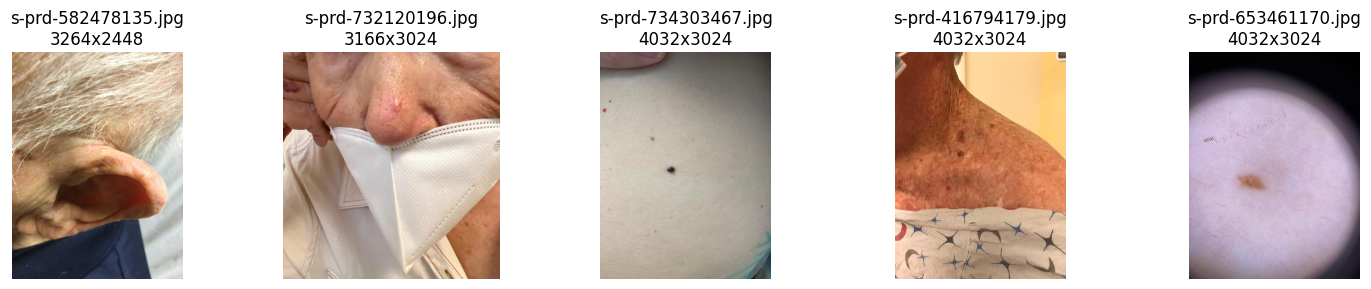

Class: Melanoma


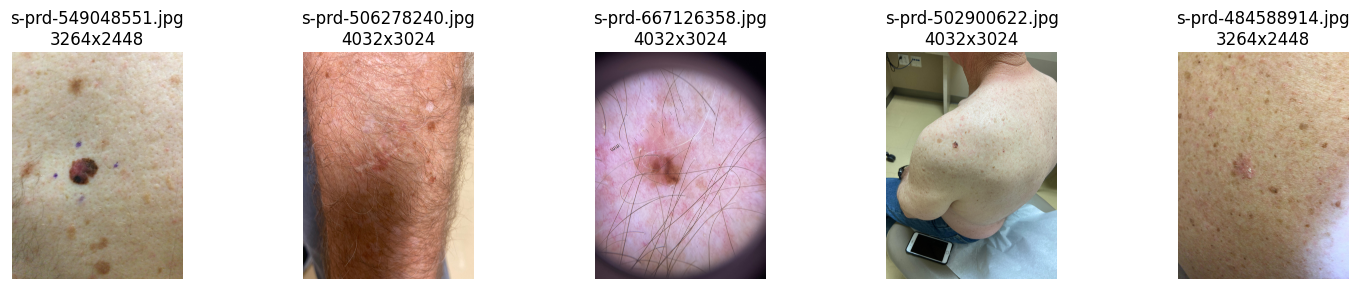

Class: SCC


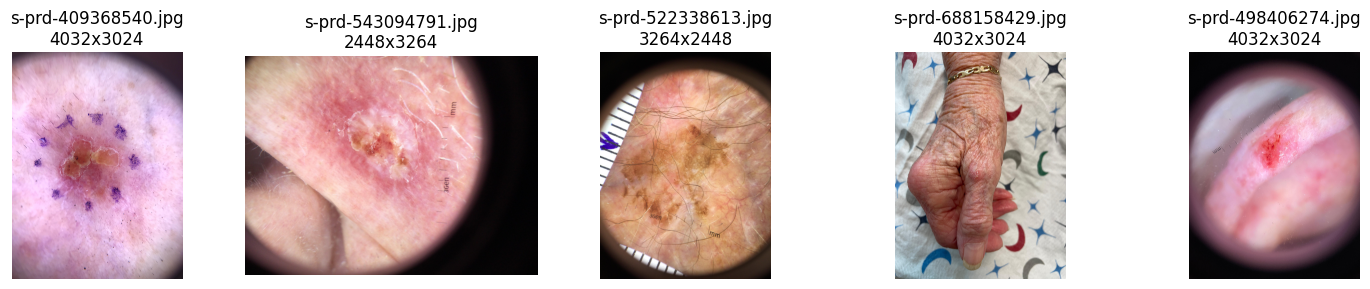

In [12]:

sorted_images_dir = Path("../DataCleaning/Sorted_Images")

classes = [d for d in sorted_images_dir.iterdir() if d.is_dir()]

for class_folder in classes:

    print(f"Class: {class_folder.name}")
   
    image_files = list(class_folder.glob("*.jpg")) + list(class_folder.glob("*.png"))
    
    # get 5 random images
    num_samples = min(5, len(image_files))
    sample_images = random.sample(image_files, num_samples)
    
    # plottington
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 3))
    if len(sample_images) == 1:
        axes = [axes]
    
    for idx, img_path in enumerate(sample_images):
        img = decode_image(str(img_path))
        axes[idx].imshow(img.permute(1, 2, 0).numpy())
        axes[idx].set_title(f"{img_path.name}\n{img.shape[1]}x{img.shape[2]}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    

Dataset as you can see has varying images with some being close up while others being far so when modeling and resizing them to 244 for example will make these little dots of cancer be like 8x8 pixels that no model ever could diagnose. 